## Time Series

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [2]:
df = pd.read_csv('RSCCASN.csv', parse_dates=True, index_col='DATE')

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.columns = ['Sales']

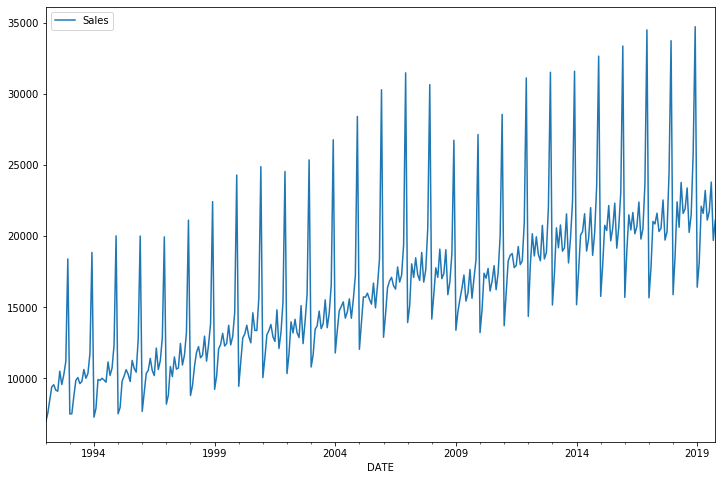

In [6]:
df.plot(figsize=(12,8))

### Train/Test Split

In [8]:
len(df)

334

##### Let's take 18 months as our test data since it is a yearly forecasted and a little over 12 months will be fine

In [9]:
len(df) - 18

316

In [10]:
test_size = 18

test_ind = len(df) - test_size

In [11]:
train = df.iloc[:test_ind]

test = df.iloc[test_ind:]

In [12]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [13]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


### Scaling the Data

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
scaled_train = scaler.fit_transform(train)

scaled_test = scaler.transform(test)

### Time Series Generator 

* This class takes-in the sequence data and creates batches for training/validation

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

##### Remember that the length of my actual batch should be less than my test_size 

##### For instance, if the length = 18, and test_size = 18 then I can't feed in a batch of 18 months and then expect to get a prediction of the 19th month with my test set

In [19]:
len(test)

18

In [20]:
length = 12

generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

##### Now let's look at our very first batch

In [21]:
X, y = generator[0]

In [22]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [24]:
len(X[0])

12

##### Now given the length of 12 months we have to predict the 13th month

In [27]:
y

array([[0.02047633]])

##### Now let's look at the 13th month of our scaled_train to see whether we are getting the correct prediction

In [29]:
scaled_train[12]

array([0.02047633])

##### Note here we are just getting one array of X and one value of y

##### If we put the batch_size = 2 we will get two sets of arrays of X and two values of y

------------------------------------------------------------------------------------------------------------------------------

### Create the Model

In [30]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, LSTM

In [31]:
n_features = 1

In [32]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation generator

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [36]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [37]:
model.fit_generator(generator, validation_data=validation_generator, epochs=20, callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 8s 26ms/step - loss: 0.0229 - val_loss: 0.0184
Epoch 2/20
304/304 [==============================] - 7s 24ms/step - loss: 0.0163 - val_loss: 0.0177
Epoch 3/20
304/304 [==============================] - 7s 24ms/step - loss: 0.0087 - val_loss: 0.0089
Epoch 4/20
304/304 [==============================] - 7s 24ms/step - loss: 0.0046 - val_loss: 0.0240
Epoch 5/20
304/304 [==============================] - 8s 25ms/step - loss: 0.0028 - val_loss: 0.0034TA: 0s
Epoch 6/20
304/304 [==============================] - 8s 25ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 7/20
304/304 [==============================] - 7s 25ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/20
304/304 [==============================] - 8s 25ms/step - loss: 0.0017 - val_loss: 9.7413e-04
Epoch 9/20
304/304 [==============================] - 7s 25ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 10/20
304/304 [==============================] - 8s 25ms/step - loss: 0.001

In [38]:
losses = pd.DataFrame(model.history.history)

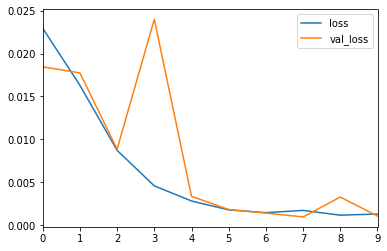

In [40]:
losses.plot()

* `Let's see on the test data how we actually performed`

-------------------------------------------------------------------------------------------------------------------------------

### Evaluate on the Test Data

In [43]:
first_eval_batch = scaled_train[-length:]

In [44]:
'''

Reshape it : 

passing one item or sample per batch

batch length of 12 months

1 y feature

'''

current_batch = first_eval_batch.reshape((1, length, n_features))

In [ ]:
model.predict(current_batch)

In [ ]:
scaled_test[0]

##### Now let's put this logic in a for loop to predict into the future for the entire test range

In [46]:
test_predictions = []

first_eval_batch = scaled_train[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of array)
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [47]:
true_predictions = scaler.inverse_transform(test_predictions)

In [48]:
test['Predictions'] = true_predictions

c:\users\tvnsk\anaconda3x\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22071.451017
2018-06-01,21589,20896.030014
2018-07-01,21919,21107.802673
2018-08-01,23381,22945.115026
2018-09-01,20260,20482.150501
2018-10-01,21473,21121.742775
2018-11-01,25831,25010.402471
2018-12-01,34706,35085.983531
2019-01-01,16410,16775.804717


##### Now from the above dataframe we have the actual values (Sales) and the predicted values (Predictions) and let's plot them to see how off we are 

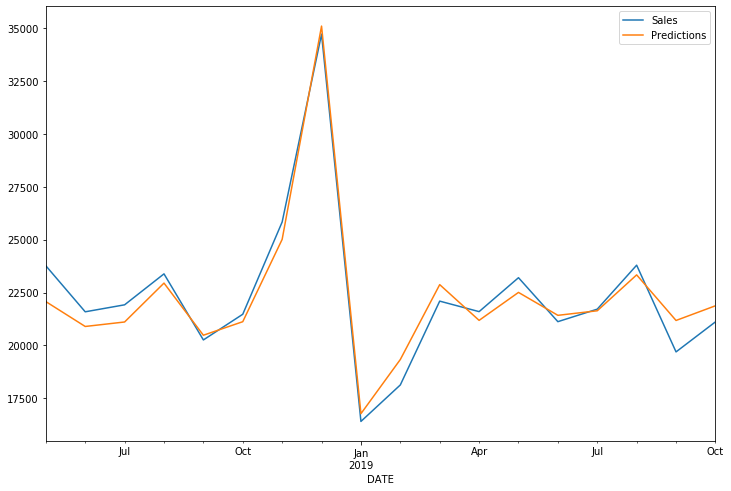

In [50]:
test.plot(figsize=(12,8))

##### At the end we are predicting off the predicted values and we call it is as true forecasting when all predicted values are not from already actual real data

##### Now if we are satisfied with the above plot i.e., performance we can go and predict the unknown Future

* `We can change the activation functions to default to see whether or not there is an improvement`

* `We can also change the no.of neurons to see the performance change`

-------------------------------------------------------------------------------------------------------------------------------

### `Retrain and Forecasting into the unknown Future`

##### `Scaling the entire Data`

In [51]:
full_scaler = MinMaxScaler()

In [52]:
scaled_full_data = full_scaler.fit_transform(df)

##### `Creating Batches`

In [53]:
length = 12 

generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

##### `Creating the Model`

In [54]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [55]:
'''
Now here what no.of epochs we should choose :

If we use Earlystop here that doesn't make sense because the purpose of using full data here we are actually forecasting 

the unknown Future

and if we do the same thing as earlier like saving some part of the actual data for testing 

we can't make the forecasting the unknown Future as we already checked and evaluated our model by not using the full actual data

and

we have seen that model is somewhat over-fitted at the 8th epoch we can choose uptill 8 epochs to retrain the model 

in order to forecast the unknown Future

'''

model.fit_generator(generator, epochs=8)

Epoch 1/8
322/322 [==============================] - 8s 26ms/step - loss: 0.0256:
Epoch 2/8
322/322 [==============================] - 8s 24ms/step - loss: 0.0198
Epoch 3/8
322/322 [==============================] - 8s 24ms/step - loss: 0.0157
Epoch 4/8
322/322 [==============================] - 8s 24ms/step - loss: 0.0074
Epoch 5/8
322/322 [==============================] - 8s 24ms/step - loss: 0.0039
Epoch 6/8
322/322 [==============================] - 8s 24ms/step - loss: 0.0027
Epoch 7/8
322/322 [==============================] - 8s 24ms/step - loss: 0.0020
Epoch 8/8
322/322 [==============================] - 8s 24ms/step - loss: 0.0012


##### `Forecasting the unknown Future`

In [58]:
forecast = []

# Replace periods with whatever forecast length we want

periods = 12 

'''
Periods = 12 means

we want to forecast 12 months in the future

And we are forecasting off the forecasted values 

So there will be huge noise if the forecasting length is high

Because each forecasting value will carry some noise in the ground

Typically, periods = length of the batch we provided earlier

Because it is the way the model has been trained on

'''

first_eval_batch = scaled_full_data[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    current_pred = model.predict(current_batch)[0]
    
    forecast.append(current_pred)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

##### `Inverse Transformations`

In [59]:
forecast = scaler.inverse_transform(forecast)

In [60]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


##### So we have predicted the next series of values after 2019-10-01 :

In [61]:
forecast

array([[26037.14656401],
       [35966.71363258],
       [16937.09191179],
       [18374.84655952],
       [21831.33189678],
       [21407.68807316],
       [22970.18126965],
       [21012.56473637],
       [21620.46548367],
       [23653.53522062],
       [19797.97074914],
       [21136.63837624]])

##### Now we want to add these forecast values with a timestamp 

##### i.e., we are going to build a forecast index with the pandas built-in tools

##### `Creating new timestamp index with pandas`

In [62]:
forecast_index = pd.date_range(start='2019-11-01', periods=periods, freq='MS')   # Since it is a monthly wise data

* [pandas frequency strings](https://stackoverflow.com/questions/35339139/where-is-the-documentation-on-pandas-freq-tags)

In [63]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

##### `Create a DataFrame that combines our Forecast values with the Forecast Index`

In [64]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['Forecast'])

In [65]:
forecast_df

,Forecast
2019-11-01,26037.146564
2019-12-01,35966.713633
2020-01-01,16937.091912
2020-02-01,18374.846560
2020-03-01,21831.331897
2020-04-01,21407.688073
2020-05-01,22970.181270
2020-06-01,21012.564736
2020-07-01,21620.465484
2020-08-01,23653.535221


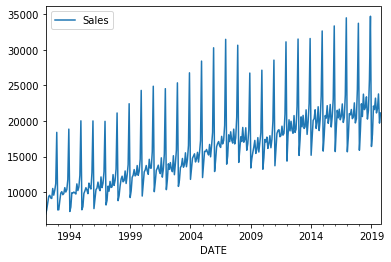

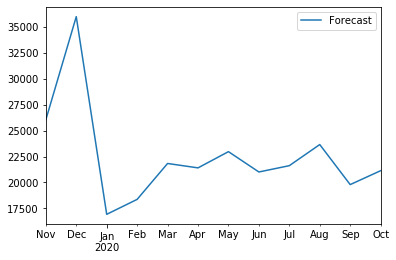

In [66]:
# Original Sales Data

df.plot()

# Forecasted_Data

forecast_df.plot()

##### `Let's plot the original sales data and the forecasted data in the same plot`

### Joining pandas plots

* https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

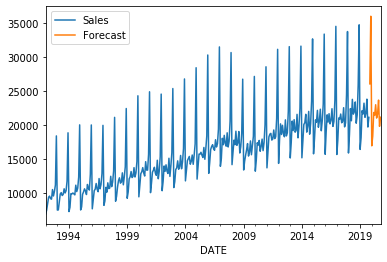

In [67]:
ax = df.plot()

forecast_df.plot(ax=ax)  # to plot them on the same axis

##### `Zoom-in`

(576, 611)

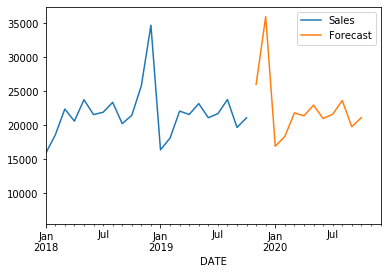

In [68]:
ax = df.plot()

forecast_df.plot(ax=ax)

plt.xlim('2018-01-01', '2020-12-01')

##### `The reason for the gap in the plot is technically those are two different dataframes and we can even concatenate them`

* `Looks like our model has forecasted pretty well`